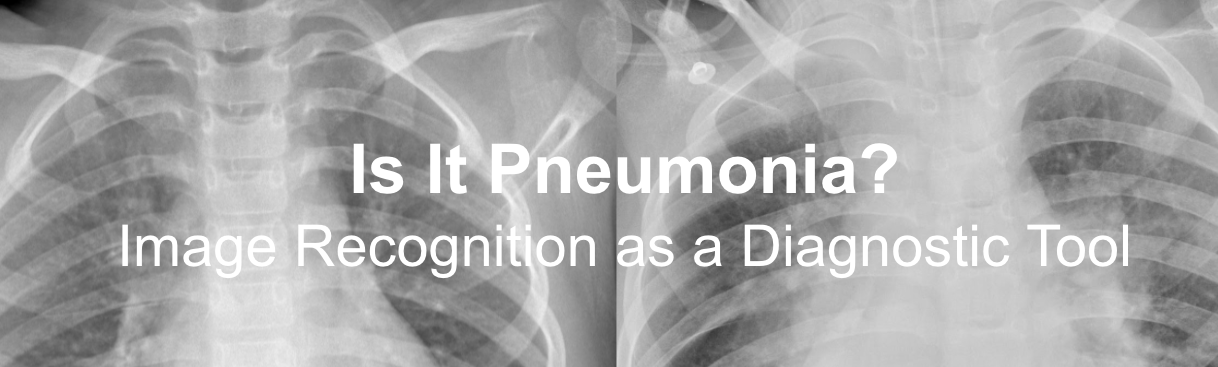

## Background
Globally, 1 in 71 children contract pneumonia every year. Unfortunately, pediatric pneumonia is also frequently fatal resulting in an estimated 2,200 deaths per day worldwide. To diagnose pediatric pneumonia, highly skilled physicians such as pediatric radiologists are needed to interpret the medical imaging. However, the distribution of these providers is highly disparate globally.

## Business Problem
Countries with few pediatric radiologists per capita may have potentially higher risks of delays in diagnosis and corresponding treatment failures. Higher costs and interventional risks may also be worsened. Thus, our team endeavored to produce a diagnostic support tool, leveraging machine learning to speed and improve diagnosis of pediatric pneumonia. We believe our diagnostic support tool will be particularly useful in helping healthcare providers in countries with few pediatric radiologists per capita.

## Data Understanding
We used 5224 pediatric chest xrays to develop a diagnostic support tool that can differentiate between a normal chest xray (CXR) and a chest xray in a pediatric patient with pneumonia. There were 1341 normal CXR, 3883 pneumonia CXR. Recall was the metric of choice as failure to properly diagnose pneumonia (or false negative) could potentially be fatal to the child. Using recall allows us to try to reduce these false negatives.

## Modeling
We used a convolutional neural network (CNN) to developed our diagnostic support tool as they’re good for image classification. CNNs are particularly strong when for image classification especially wehn geared towards color images.

In [1]:
# Importing libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense
from keras.models import Model
from keras.metrics import Recall
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers

import os
import glob
import shutil



In [2]:
classes = ['normal', 'pneumonia']


# Instantiating ImageDataGenerator and normalizing the RGB values
traingen = ImageDataGenerator(rescale=1/255, validation_split=0.12)
testgen = ImageDataGenerator(rescale=1/255)


# Creating training data generator
train_data = traingen.flow_from_directory(
    # Specifying location of training data
    directory='data_split/train',
    # Re-sizing images to 200x200
    target_size=(200, 200),
    classes = classes,
    # Class mode to binary to recoginize the two directories "Normal" and "PNA" as the labels
    class_mode='binary',
    batch_size=64,
    subset = 'training',
    seed=16
)
# Creating a validation data generator
val_data = traingen.flow_from_directory(
        directory = 'data_split/train',
        target_size=(200, 200),
        batch_size=64,
        classes = classes,
        class_mode='binary',
        subset='validation',
        seed=16
)    
    
    
# Creating testing data generator
test_data = testgen.flow_from_directory(
    # Specifying location of testing data
    directory='data_split/test',
    # Re-sizing images to 200x200
    target_size=(200, 200),
    classes = classes,
    # Class mode to binary to recoginize the two directories "Normal" and "PNA" as the labels
    class_mode='binary',
    batch_size=64,
    seed=16
)



Found 4599 images belonging to 2 classes.
Found 625 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Create classification for images.

In [3]:
# Putting image classification into a dataframe
classes_df = pd.DataFrame(train_data.classes)
values = classes_df.value_counts()

In [4]:
# Review classes
classes_df

,0
0,0
1,0
2,0
3,0
4,0
...,...
4594,1
4595,1
4596,1
4597,1


In [5]:
# Giving the data binary labels to allow for visialization of class imbalance below.
class_dict = {0:'Normal', 1:'PNA'}
classes_df[0] = classes_df[0].map(class_dict)

In [6]:
# Image counting
image_interpretation = classes_df[0].value_counts()
image_interpretation

PNA       3418
Normal    1181
Name: 0, dtype: int64

In [7]:
# Percent of PNA vs normal chest xrays
classes_df[0].value_counts(normalize=True)

PNA       0.743205
Normal    0.256795
Name: 0, dtype: float64

In [8]:
image_interpretation.index

Index(['PNA', 'Normal'], dtype='object')

Now that we have our train data and classification, let's visualize the images for preliminary inspection.

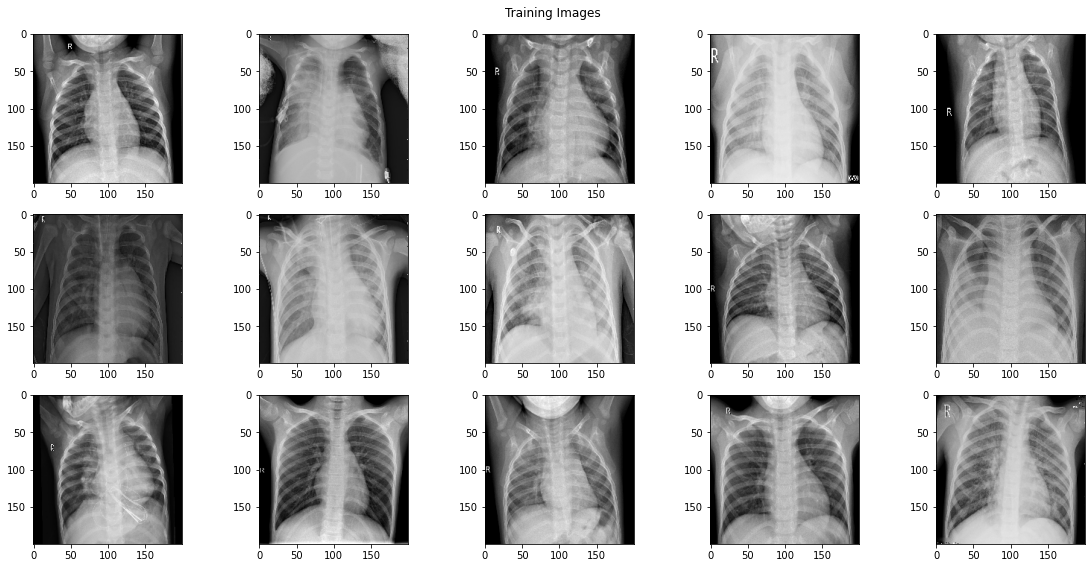

In [9]:
# Visualize
train_batch = train_data.next()
fig, axes = plt.subplots(3, 5, figsize=(16, 8))
    
for i in range(15):
    # Load image into numpy array and re-scale
    img = np.array(train_batch[0][i] * 255, dtype='uint8')
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
fig.suptitle('Training Images')
plt.tight_layout()
plt.show()

### Baseline Model
Essentially a logistic regression model with a single node output layer using a sigmoid activation function and 1 epocs.

In [10]:
# Building baseline logistic regression model
model_0 = keras.Sequential(
    [   keras.Input(shape=(200,200,3)), 
        keras.layers.Flatten(), 
        keras.layers.Dense(1, activation="sigmoid"),
    ])
model_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 120000)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 120001    
Total params: 120,001
Trainable params: 120,001
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Compile model
model_0.compile(loss='binary_crossentropy',
              metrics=keras.metrics.Recall())

In [12]:
# Fit model
model_0.fit(train_data, epochs=1, batch_size=64, validation_data=(val_data))

72/72 [==============================] - 87s 1s/step - loss: 8.9354 - recall: 0.7955 - val_loss: 1.2573 - val_recall: 0.9548


### Model 1
Added a 8 node hidden layer, continuing sigmoid activation function, rmsprop optimizer, and 3 epochs.

In [13]:
# Building first model
model_1 = keras.Sequential(
    [   keras.Input(shape=(200,200,3)),
        keras.layers.Dense(8, activation="sigmoid"),
        keras.layers.Flatten(),
        keras.layers.Dense(1, activation="sigmoid"),
    ])
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200, 200, 8)       32        
_________________________________________________________________
flatten_1 (Flatten)          (None, 320000)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 320001    
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Compile model
model_1.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
              metrics=keras.metrics.Recall())

In [15]:
# Fit model
model_1.fit(train_data, epochs=3, batch_size=64, validation_data=(val_data))

Epoch 1/3
72/72 [==============================] - 90s 1s/step - loss: 33.9459 - recall_1: 0.7194 - val_loss: 5.3862 - val_recall_1: 1.0000
Epoch 2/3
72/72 [==============================] - 92s 1s/step - loss: 26.3062 - recall_1: 0.7288 - val_loss: 30.3676 - val_recall_1: 1.0000
Epoch 3/3
72/72 [==============================] - 91s 1s/step - loss: 22.6979 - recall_1: 0.7504 - val_loss: 22.2049 - val_recall_1: 0.0000e+00


### Model 2
Adding more layers with halfing numbers of nodes, switching to relu activation for the hidden layers, and adding Adam optimizer and 5 epoch  run for improved model performance

1st layer: 16 node hidden Conv2D layer, relu activation function<br/>
2nd layer: 8 node hidden Dense layer, relu activation function<br/>
3rd layer: Single node Dense layer, sigmoid activation function<br/>
Adam optimizer and 5 epochs

In [27]:
# CNN model with 2 convolutional layers
model_2 =  keras.Sequential(
    [   keras.Input(shape=(200,200,3)),
        keras.layers.Conv2D(32, (3,3), activation="relu"),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (5,5), activation="relu"),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid"),
    ])

model_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 95, 95, 64)        51264     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 47, 47, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 141376)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                9048128   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [28]:
# Compile model
model_2.compile(optimizer=keras.optimizers.Adam(lr=.003),
                loss='binary_crossentropy',
              metrics=keras.metrics.Recall())

In [29]:
# Fit model
training_sample = train_data.n
val_sample = val_data.n
model_2.fit(train_data, epochs=5, batch_size=64, 
            steps_per_epoch=int((training_sample//64)-1),
            validation_data=val_data)

Epoch 1/5
70/70 [==============================] - 168s 2s/step - loss: 0.6977 - recall_4: 0.8442 - val_loss: 0.4438 - val_recall_4: 0.8860
Epoch 2/5
70/70 [==============================] - 169s 2s/step - loss: 0.3476 - recall_4: 0.9199 - val_loss: 0.3621 - val_recall_4: 0.9290
Epoch 3/5
70/70 [==============================] - 174s 2s/step - loss: 0.2733 - recall_4: 0.9317 - val_loss: 0.3771 - val_recall_4: 0.9312
Epoch 4/5
70/70 [==============================] - 179s 3s/step - loss: 0.2216 - recall_4: 0.9360 - val_loss: 0.3284 - val_recall_4: 0.8925
Epoch 5/5
70/70 [==============================] - 170s 2s/step - loss: 0.1541 - recall_4: 0.9588 - val_loss: 0.3133 - val_recall_4: 0.8946


Model_2 appears to be overfitting slightly given the 96% recall on the training data is more than the 90% on the train data. Let's see how it performs on our holdout test data:

In [32]:
# evaluating this model on our test data
print(model_2.metrics_names)
model_2.evaluate(test_data)

['loss', 'recall_4']
10/10 [==============================] - 15s 1s/step - loss: 0.8132 - recall_4: 0.9487


[0.8132181763648987, 0.9487179517745972]

95% recall on the test data is pretty good! lets see what adding an additional layer will do below.

### Model 3
Adding more layers with halfing numbers of nodes, bumping up to 10 epoch run for improved model performance

1st layer: 64 node hidden Conv2D layer, relu activation function<br/>
2nd layer: 32 node hidden Conv2D layer, relu activation function<br/>
3d layer: 16 node hidden Dense layer, relu activation function<br/>
4th layer: Single node Dense layer, sigmoid activation function<br/>
Adam optimizer and 10 epochs

In [33]:
# adding another for total 3 convolutional layers
model_3 = keras.Sequential(
    [   keras.Input(shape=(200,200,3)),
        keras.layers.Conv2D(64, (5,5), activation="relu"),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(32, (5,5), activation="relu"),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(32, (3,3), activation="relu"),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid"),
    ])
model_3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 196, 196, 64)      4864      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 98, 98, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 94, 94, 32)        51232     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 15488)            

In [34]:
# Compile model
model_3.compile(optimizer=keras.optimizers.Adam(lr=.003),
                loss='binary_crossentropy',
              metrics=keras.metrics.Recall())

In [35]:
# Fit model
model_3.fit(train_data, epochs=10, batch_size=64, 
                        steps_per_epoch=int((training_sample//64)-1),
                        validation_data=(val_data))

Epoch 1/10
70/70 [==============================] - 278s 4s/step - loss: 0.7220 - recall_5: 0.9635 - val_loss: 0.3811 - val_recall_5: 0.9484
Epoch 2/10
70/70 [==============================] - 277s 4s/step - loss: 0.4426 - recall_5: 0.8963 - val_loss: 0.3851 - val_recall_5: 0.9183
Epoch 3/10
70/70 [==============================] - 274s 4s/step - loss: 0.2190 - recall_5: 0.9539 - val_loss: 0.3220 - val_recall_5: 0.9871
Epoch 4/10
70/70 [==============================] - 273s 4s/step - loss: 0.1763 - recall_5: 0.9595 - val_loss: 0.2088 - val_recall_5: 0.9398
Epoch 5/10
70/70 [==============================] - 274s 4s/step - loss: 0.1589 - recall_5: 0.9663 - val_loss: 0.1926 - val_recall_5: 0.9656
Epoch 6/10
70/70 [==============================] - 275s 4s/step - loss: 0.1178 - recall_5: 0.9729 - val_loss: 0.1835 - val_recall_5: 0.9355
Epoch 7/10
70/70 [==============================] - 274s 4s/step - loss: 0.2106 - recall_5: 0.9603 - val_loss: 3.4143 - val_recall_5: 1.0000
Epoch 8/10
70

`model_3` appears to be potentially less overfitting than model 2. Below we evaluate this model on the test data

In [36]:
#evaluating model_3 on the holdout test data
model_3.evaluate(test_data)

10/10 [==============================] - 12s 1s/step - loss: 0.7809 - recall_5: 0.9769


[0.7808693647384644, 0.9769230484962463]

nearly 98% recall on new (test) data. This means, as a diagnostic support tool `model_3` only fails to diagnose just over 1 out of every 50 xrays it comes across! 

In [85]:
#preparing data for confusion matrix
y_pred = np.rint(model_3.predict(test_data))
y_pred = y_pred.reshape(624)
y_true = test_data.classes

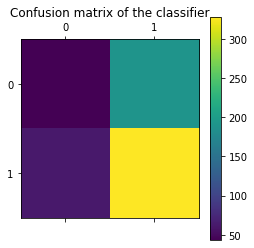

In [97]:
#plotting confusion matrix
from sklearn.metrics import confusion_matrix, RocCurveDisplay
import pylab as pl
cm = confusion_matrix(y_true, y_pred)
pl.matshow(cm)
pl.title('Confusion matrix of the classifier')
pl.colorbar()
pl.show()

It appears that our high recall rate is in part due to *over-diagnosing*, as there are a lot of false positives, and very few true negatives. Future work would try to train the model on accuracy so it can be a valuable tool for classification by actually saving time.

## Conclusions
Given recent events, including a global pandemic that frequently resulted in pneumonia for those affected and overwhelmed healthcare resources, having a diagnostic support tool to accelerate diagnosis without adding strain to hospital staff is of enormous value. Our diagnostic support tool accurately identifies pediatric pneumonia 100% of the time. We think our diagnostic support tool could be particularly valuable in underserviced communities around the world where pediatric radiologists are scarce.

## Future Considerations
With more time and data we believe our diagnostic support tool can be further improved and may be applicable for evaluation of adult chest xrays. We also plan to refine our model toaccurately differentiate between bacterial and viral pneumonia. Additionally, incorporation clinical data, such vitals signs and blood lab tests, shoulder further improve our diagnostic support tool.